<a href="https://colab.research.google.com/github/Darshil420/Probation-Projects-2025/blob/main/linearregression_cabfareprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing files and libraries

In [16]:
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
fileid = "1tqt-aTfLFjb4AWe3QW53VM8vUAhyUQ36"
gdown.download(f"https://drive.google.com/uc?id={fileid}", "taxi_trip_pricing.csv", quiet=False)
df = pd.read_csv("taxi_trip_pricing.csv")
print(type(df))

Downloading...
From: https://drive.google.com/uc?id=1tqt-aTfLFjb4AWe3QW53VM8vUAhyUQ36
To: /content/taxi_trip_pricing.csv
100%|██████████| 67.3k/67.3k [00:00<00:00, 4.55MB/s]

<class 'pandas.core.frame.DataFrame'>


data cleaning and preprocessing


   Trip_Distance_km Time_of_Day Day_of_Week  Passenger_Count  \
0             19.35     Morning     Weekday              3.0   
1             47.59   Afternoon     Weekday              1.0   
2             36.87     Evening     Weekend              1.0   
3             30.33     Evening     Weekday              4.0   
4               NaN     Evening     Weekday              3.0   

  Traffic_Conditions Weather  Base_Fare  Per_Km_Rate  Per_Minute_Rate  \
0                Low   Clear       3.56         0.80             0.32   
1               High   Clear        NaN         0.62             0.43   
2               High   Clear       2.70         1.21             0.15   
3                Low     NaN       3.48         0.51             0.15   
4               High   Clear       2.93         0.63             0.32   

   Trip_Duration_Minutes  Trip_Price  
0                  53.82     36.2624  
1                  40.57         NaN  
2                  37.27     52.9032  
3                 11

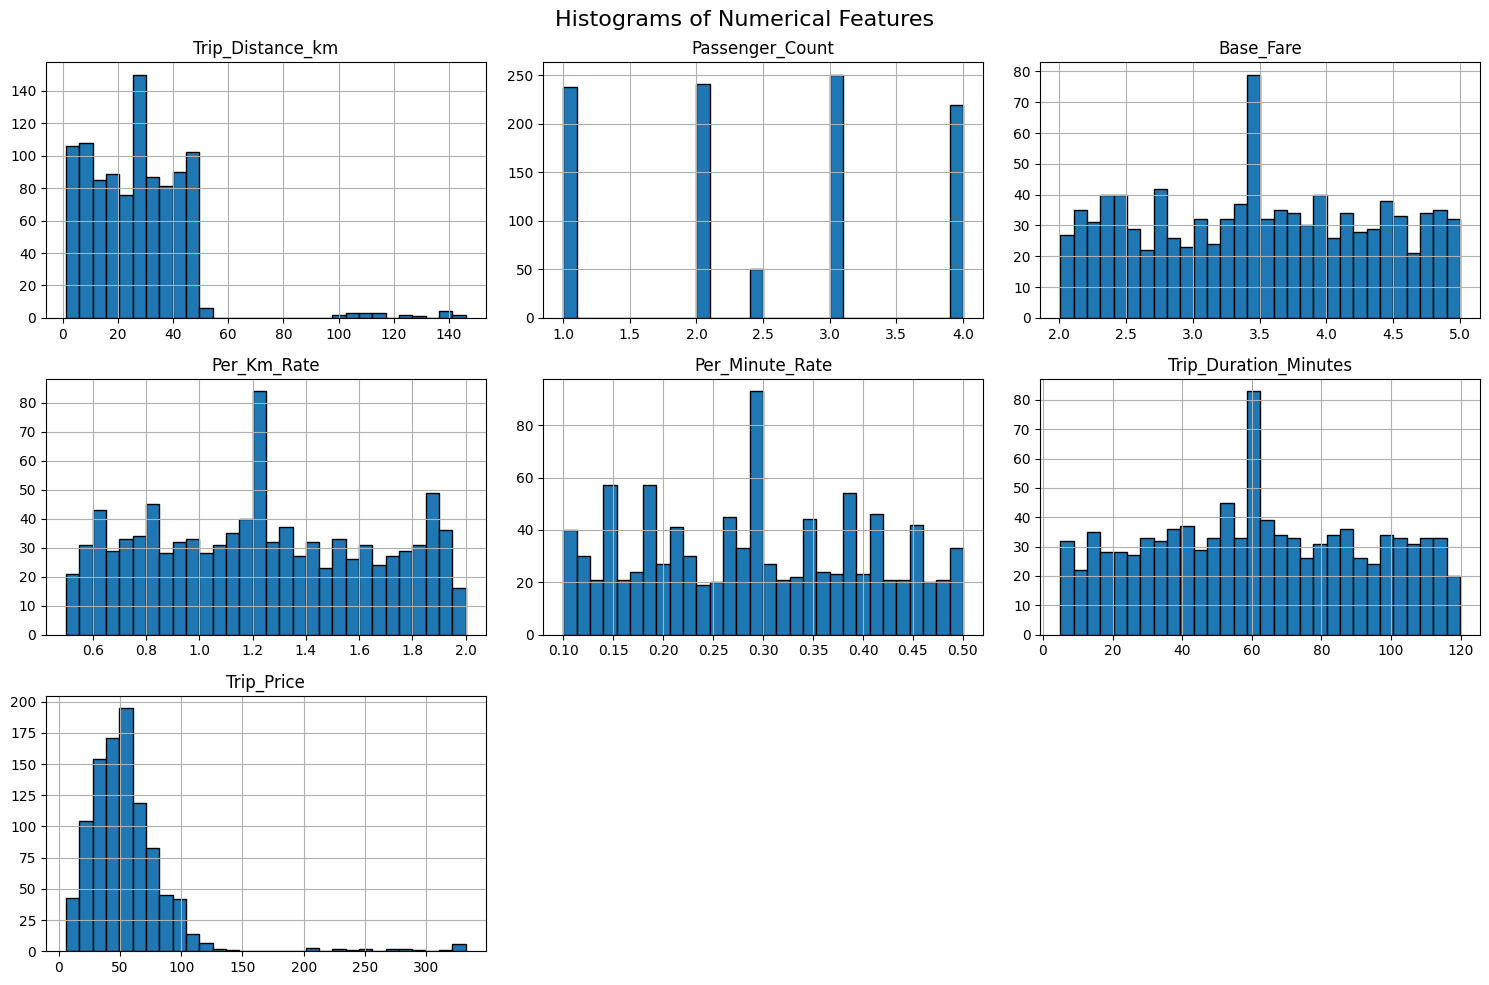

In [17]:
print(df.head())
print(df.info())
print(df.describe())
missing=df.isnull().sum()
print(missing)
#data cleaning
df.drop_duplicates(subset=None,keep='first',inplace=True)
#categorical datacleaning
for col in df.select_dtypes(include='object').columns:
    modeval=df[col].mode(dropna=True)
    df[col]=df[col].fillna(modeval[0])

#numerical datacleaning
for col in df.select_dtypes(include='number').columns:
    skewval=df[col].skew()
    if -0.5<skewval<0.5:
        df[col]=df[col].fillna(df[col].mean())
        method="mean"
    else:
        df[col]=df[col].fillna(df[col].median())
        method="median"

    print(f"{col}: skew={skewval:.3f},method={method}")

#outliers check
numerical_cols = df.select_dtypes(include=['int64','float64']).columns
# histograms
df[numerical_cols].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()


data encoding

/tmp/ipython-input-53824484.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Day_of_Week'] = df['Day_of_Week'].replace({"Weekday":1, "Weekend":0})
/tmp/ipython-input-53824484.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Traffic_Conditions"] = df["Traffic_Conditions"].replace({"Low":0, "Medium":1, "High":2})


   Trip_Distance_km  Day_of_Week  Passenger_Count  Traffic_Conditions  \
0             19.35            1              3.0                   0   
1             47.59            1              1.0                   2   
2             36.87            0              1.0                   2   
3             30.33            1              4.0                   0   
4             25.83            1              3.0                   2   

   Base_Fare  Per_Km_Rate  Per_Minute_Rate  Trip_Duration_Minutes  Trip_Price  \
0   3.560000         0.80             0.32                  53.82     36.2624   
1   3.502989         0.62             0.43                  40.57     50.0745   
2   2.700000         1.21             0.15                  37.27     52.9032   
3   3.480000         0.51             0.15                 116.81     36.4698   
4   2.930000         0.63             0.32                  22.64     15.6180   

   Time_of_Day_Evening  Time_of_Day_Morning  Time_of_Day_Night  Weather_Ra

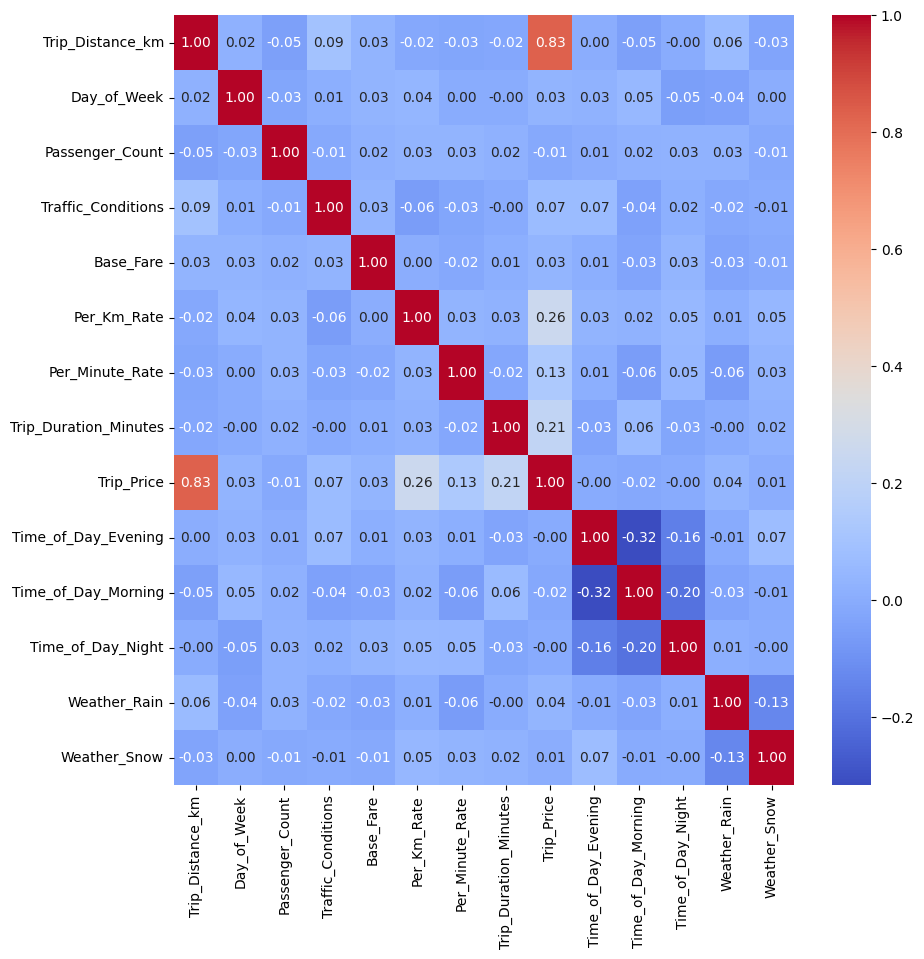

In [18]:
#encoding(hot,binary,ordinal)
df = pd.get_dummies(df, columns=['Time_of_Day','Weather'], drop_first=True)
df['Day_of_Week'] = df['Day_of_Week'].replace({"Weekday":1, "Weekend":0})
df["Traffic_Conditions"] = df["Traffic_Conditions"].replace({"Low":0, "Medium":1, "High":2})
print(df.head())

#correlation heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.show()

define features and target values


In [19]:
X=df.drop("Trip_Price", axis=1)   # Features
Y=df["Trip_Price"]                # Target
print(X)
print(Y)

     Trip_Distance_km  Day_of_Week  Passenger_Count  Traffic_Conditions  \
0               19.35            1              3.0                   0   
1               47.59            1              1.0                   2   
2               36.87            0              1.0                   2   
3               30.33            1              4.0                   0   
4               25.83            1              3.0                   2   
..                ...          ...              ...                 ...   
995              5.49            0              4.0                   1   
996             45.95            1              4.0                   1   
997              7.70            1              3.0                   0   
998             47.56            1              1.0                   0   
999             22.85            0              3.0                   1   

     Base_Fare  Per_Km_Rate  Per_Minute_Rate  Trip_Duration_Minutes  \
0     3.560000     0.800000 

splitting and scaling the data

In [20]:
x_train,x_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)
scaler=StandardScaler()
X_train=scaler.fit_transform(x_train)
X_test=scaler.transform(x_test)

creating and training the model

In [21]:
model = LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

model predictions and evaluation

[34.47655316 -0.56232388 -0.04019784  0.22283126  0.17682901 10.15362391
  6.37226531  8.99385045 -0.53090265  0.34661622 -0.44345456 -0.2562098
  0.30259694]
56.943602119103176


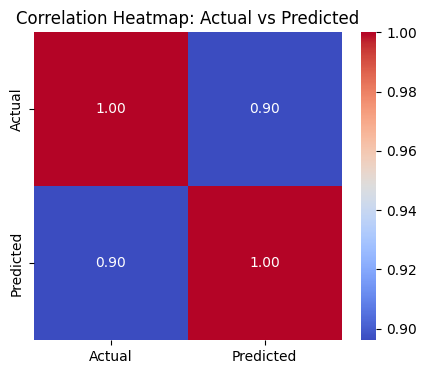

mean sbsolute rrror: 9.824470115337347
mean dquared rrror: 261.037464685939
root mean squared error: 16.156653882717766
R² Score: 0.8016800444291419


In [25]:
#prediction
Y_pred=model.predict(X_test)
print(model.coef_)
print(model.intercept_)

#heatmap btw actual vs predicted values
df_corr=pd.DataFrame({
    "Actual": Y_test,
    "Predicted": Y_pred
})

plt.figure(figsize=(5,4))
sns.heatmap(df_corr.corr(),annot=True,cmap="coolwarm",fmt=".2f",square=True)
plt.title("Correlation Heatmap: Actual vs Predicted")
plt.show()

#evaluation
mae=mean_absolute_error(Y_test,Y_pred)
mse=mean_squared_error(Y_test,Y_pred)
rmse=np.sqrt(mse)
r2=r2_score(Y_test,Y_pred)

print("mean sbsolute rrror:",mae)
print("mean dquared rrror:",mse)
print("root mean squared error:",rmse)
print("R² Score:",r2)


using lasso to improve accuracy (very less multicollinearity)

mean absolute error:  9.562551051486304
mean squared error:  260.37486425459315
R2 score:  0.8021834468363935


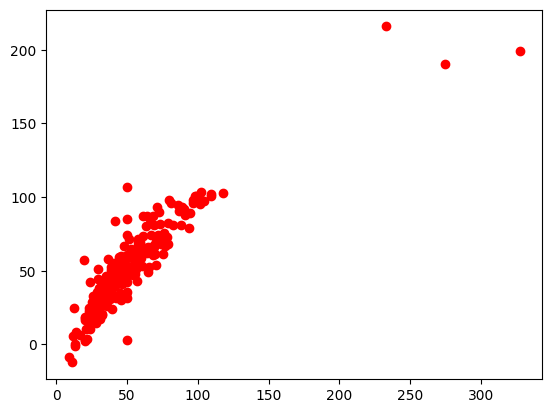

In [23]:
lasso=Lasso()
lasso.fit(X_train,Y_train)
Y_pred=lasso.predict(X_test)

mae=mean_absolute_error(Y_test,Y_pred)
mse=mean_squared_error(Y_test,Y_pred)
score=r2_score(Y_test,Y_pred)

print("mean absolute error: ",mae)
print("mean squared error: ",mse)
print("R2 score: ",score)

plt.scatter(Y_test,Y_pred,color="red")
plt.show()